<h1><center>Simulating Chaotic Rayleigh-Bénard Convection</center></h1>

<h3><center>Rey Koki</center></h3>

## Rayleigh-Bénard Convection

This is a simplified 2D model that can be thought of a top and a bottom plate with a liquid in constant phase. The bottom plate is being held at a constant temperature $T_0$ while the top plate is being held at a constant temperature $T_1$. 

<h3><center>simple convection rolls:</center></h3>

\begin{align} 
T_0 > T_1
\end{align}


![convection](convection.png)


The system above is not stable, when the bottom plate has a higher temperature than the top plate, it will result in the top liquid having a higher density than the bottom liquid. If the temperature gradient is high enough, the bouyancy force will cause the bottom liquid to rise and the top liquid to sink. This convection is Rayleigh-Benard Convection and will only occur when the boyancy force is able to overcome the frictional (viscosity) and gravitational forces that usually keep the lower liquid at the bottom.



## Equations for Convection

#### Assumptions

1. The liquid is shallow

2. Pressure does not affect density

3. The speed of the fluid is much less than the speed of sound


<h4><center>Momentum Conservation (Navier Stokes equation)</center></h4>

\begin{align} 
\frac{\partial u}{\partial t} - \Delta u + u \cdot \nabla u + \nabla p + \frac{Ra}{Pr} T =  0 \\
\end{align}

<h4><center>Mass Conservation</center></h4>

\begin{align} 
\nabla \cdot u = 0 \\
\end{align}

<h4><center>Energy Conservation</center></h4>

\begin{align} 
\frac{\partial T}{\partial t} - \frac{1}{Pr} \Delta T +  u \cdot \nabla T = 0
\end{align}

- $Ra$ - Rayleigh number
- $Pr$ - Prandtl number
- $u$ - velocity
- $p$ - pressure
- $T$ - temperature


In [1]:
from firedrake import *
from firedrake.petsc import PETSc
import matplotlib.pyplot as plt

## Constants

<h3><center>two key physical parameters</center></h3>
Rayleigh number $Ra$

- amount of convection

\begin{align}
Ra = \frac{g \alpha \Delta T h^3}{\nu \kappa} \\
\end{align}

Prandtl number $Pr$
- ratio of viscosity to momentum


\begin{align}
Pr = \frac{\nu}{k} \\
\end{align}


- $\kappa$ - thermal diffusivity
- $\nu$ - viscosity
- $\alpha$ - thermal expansion coefficient
- $g$ - gravity

In [2]:
# Rayleigh number
Ra = Constant(2e4)
# Prandtl number
Pr = Constant(1)

# gravity points down
g = Constant((0, -1))

# time step
dt = .1

## Meshes

The numbers assigned to each border are necessary when defining boundary conditions.

Our true mesh will be 128x128 cells.

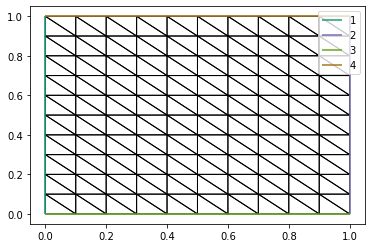

In [3]:
N = 10
# structured grid
mesh = UnitSquareMesh(N, N)
fig, axes = plt.subplots()
triplot(mesh, axes=axes)
axes.legend();

In [4]:
N = 64
mesh = UnitSquareMesh(N, N)

In [5]:
#polynomial degree of the pressure space
degree = 1

# velocity function space
V = VectorFunctionSpace(mesh, "CG", degree + 1)
# used for final projection
V_out = VectorFunctionSpace(mesh, "CG", degree)
# pressure function space
P = FunctionSpace(mesh, "CG", degree)
# temperature function space
T = FunctionSpace(mesh, "CG", degree)
# mixed function space
Z = V * P * T

# previous timestep
upT_ = Function(Z, name="upT_prev")
# current timestep
upT = Function(Z, name='upT')

# separate velocity/pressure/temperature
u, p, Temp = split(upT)
u_, p_, Temp_ = split(upT_)
# use a test function for the wweak form
v, q, S = TestFunctions(Z)


In [6]:
# weak formulation of momentum equation
F0 = (inner(u - u_, v) / dt 
      + inner(grad(u), grad(v)) 
      + inner(dot(grad(u), u), v) 
      - inner(p, div(v))
      - (Ra/Pr)*inner(Temp*g, v))*dx

# weak formulation of mass equation
F1 = inner(div(u), q)*dx

# weak formulation for energy equation
F2 = ((Temp - Temp_) * S / dt  
      + inner(dot(grad(Temp), u), S)
      + 1/Pr * inner(grad(Temp), grad(S)))*dx

F = F0 + F1 + F2

### Boundary Conditions

Heat is applied from bottom to top so that the temperature gradient is enforced parallel to the graviation.


\begin{equation}
    u = 0, \quad x = y = 0,1
\end{equation} 

\begin{equation}
    T = 1, \quad y = 0
\end{equation}

\begin{equation}
    T = 0, \quad y = 1
\end{equation} 

<h4><center>Neumann (closed)</center></h4>

\begin{equation}
    \frac{\partial T}{\partial x} = 0 , \quad x = 0,1
\end{equation} 


In [7]:

bcs = [
    DirichletBC(Z.sub(0), Constant((0, 0)), (1, 2, 3, 4)), 
    DirichletBC(Z.sub(2), Constant(1.0), (3,)),
    DirichletBC(Z.sub(2), Constant(0.0), (4,))
    ]


nullspace = MixedVectorSpaceBasis(Z, 
                                  [Z.sub(0), # velocity
                                   VectorSpaceBasis(constant=True), # pressure
                                   Z.sub(2)]) # Temperature

## Initial Conditions

**Temperature**


gradient calculated from:

> $T_o = 1$ and $T_1 = 0$


**Velocity**

> $u_o = 0$



**Pressure**

Calculated from $u_o$ and $T_o$



In [8]:
parameters1 = {"mat_type": "matfree",
              "snes_monitor": None,
              "ksp_type": "gmres",
              "pc_type": "fieldsplit",
              "pc_fieldsplit_type": "multiplicative",

# We want to split the Navier-Stokes part off from the temperature
# variable. ::

              "pc_fieldsplit_0_fields": "0,1",
              "pc_fieldsplit_1_fields": "2",

# We'll invert the Navier-Stokes block with MUMPS::

              "fieldsplit_0_ksp_type": "preonly",
              "fieldsplit_0_pc_type": "python",
              "fieldsplit_0_pc_python_type": "firedrake.AssembledPC",
              "fieldsplit_0_assembled_pc_type": "lu",
              "fieldsplit_0_assembled_pc_factor_mat_solver_type": "mumps",

# the temperature block will also be inverted directly, but with plain
# LU.::

              "fieldsplit_1_ksp_type": "preonly",
              "fieldsplit_1_pc_type": "python",
              "fieldsplit_1_pc_python_type": "firedrake.AssembledPC",
              "fieldsplit_1_assembled_pc_type": "lu"}

parameters2 = {"mat_type": "matfree",
              "snes_monitor": None,

# We'll use inexact GMRES solves to invert the Navier-Stokes block, so
# the preconditioner as a whole is not stationary, hence we need
# flexible GMRES. ::

             "ksp_type": "fgmres",
             "ksp_gmres_modifiedgramschmidt": True,
             "pc_type": "fieldsplit",
             "pc_fieldsplit_type": "multiplicative",

# Again we split off Navier-Stokes from the temperature block ::

             "pc_fieldsplit_0_fields": "0,1",
             "pc_fieldsplit_1_fields": "2",

# which we solve inexactly using preconditioned GMRES. ::

             "fieldsplit_0": {
                 "ksp_type": "gmres",
                 "ksp_gmres_modifiedgramschmidt": True,
                 "ksp_rtol": 1e-2,
                 "pc_type": "fieldsplit",
                 "pc_fieldsplit_type": "schur",
                 "pc_fieldsplit_schur_fact_type": "lower",

# Invert the velocity block with a single V-cycle of algebraic
# multigrid::

                 "fieldsplit_0": {
                     "ksp_type": "preonly",
                     "pc_type": "python",
                     "pc_python_type": "firedrake.AssembledPC",
                     "assembled_pc_type": "hypre"
                 },

# and approximate the Schur complement inverse with PCD. ::

                 "fieldsplit_1": {
                      "ksp_type": "preonly",
                      "pc_type": "python",
                      "pc_python_type": "firedrake.PCDPC",

# We need to configure the pressure mass and Poisson solves, along with
# how to apply the convection-diffusion operator.  For the latter, we
# will use an assembled operator this time round. ::

                      "pcd_Mp_ksp_type": "preonly",
                      "pcd_Mp_pc_type": "ilu",
                      "pcd_Kp_ksp_type": "preonly",
                      "pcd_Kp_pc_type": "hypre",
                      "pcd_Fp_mat_type": "aij"
                 }
             },

# Now for the temperature block, we use a moderately coarse tolerance
# for algebraic multigrid preconditioned GMRES. ::

            "fieldsplit_1": {
                 "ksp_type": "gmres",
                 "ksp_rtol": "1e-4",
                 "pc_type": "python",
                 "pc_python_type": "firedrake.AssembledPC",
                 "assembled_pc_type": "hypre"
            }
       }



In [9]:
# first solve for preconditioner
solve(F == 0, upT, bcs=bcs, nullspace=nullspace,
      solver_parameters={"mat_type": "aij",
                        "snes_monitor": None,
                        "ksp_type": "gmres",
                        "pc_type": "lu",
                        "pc_factor_mat_solver_type": "mumps"})

# initial condition set to zero
upT.assign(0)

# second solve for preconditioner
solve(F == 0, upT, bcs=bcs, nullspace=nullspace,
      solver_parameters=parameters1)



In [10]:
appctx = {"velocity_space": 0} # intial condition of velocity for solver
upT.assign(0) # current time step initial condition
upT_.assign(0) # previous time step initial condtion

# starting time
t = 0.0
# ending time
end = 1

u, p, Temp = upT.split()
results = [project(u, V_out, name="Velocity")] # record initial condition

while (t <= end):
    t += dt
    # solve
    solve(F == 0, upT, bcs=bcs, nullspace=nullspace,
          solver_parameters=parameters2, appctx=appctx)
    # set previous to current
    upT_.assign(upT)
    u, p, Temp = upT.split()
    results.append(project(u, V_out, name="Velocity"))


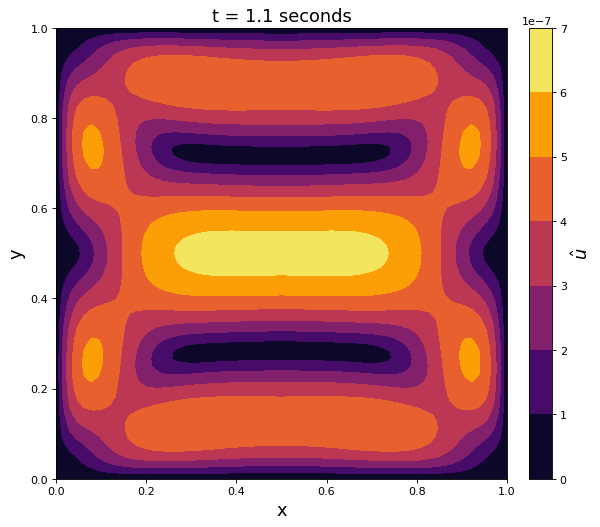

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.animation import FuncAnimation

fig = plt.figure(figsize=(8, 8), dpi=80);
ax = fig.add_subplot(111);

div = make_axes_locatable(ax);
cax = div.append_axes('right', '5%', '5%');

def plot_final():
    u = results[-1]
    t = round(1.1, 1)
    ax.clear()
    ax.set_aspect("equal")
    contours = tricontourf(u,  axes=ax, cmap="inferno")
    cax.cla()
    cb = fig.colorbar(contours, cax=cax)
    ax.set_title('t = {} seconds'.format(t))
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    cb.set_label('$\hat{u}$')
    
plot_final()

def animate(i):
    u = results[i]
    t = round(i*dt, 1)
    ax.clear()
    ax.set_aspect("equal")
    contours = tricontourf(u,  axes=ax, cmap="inferno")
    cax.cla()
    cb = fig.colorbar(contours, cax=cax)
    ax.set_title('t = {} seconds'.format(t), fontsize=16)
    ax.set_xlabel('x', fontsize=16)
    ax.set_ylabel('y', fontsize=16)
    cb.set_label('$\hat{u}$', fontsize=16)
    
interval = 6e3 * float(dt)
anim = FuncAnimation(fig, animate, frames=len(results), interval=interval)


f = 'images/results_2e4.gif'
writergif = animation.PillowWriter(fps=2) 
anim.save(f, writer=writergif);


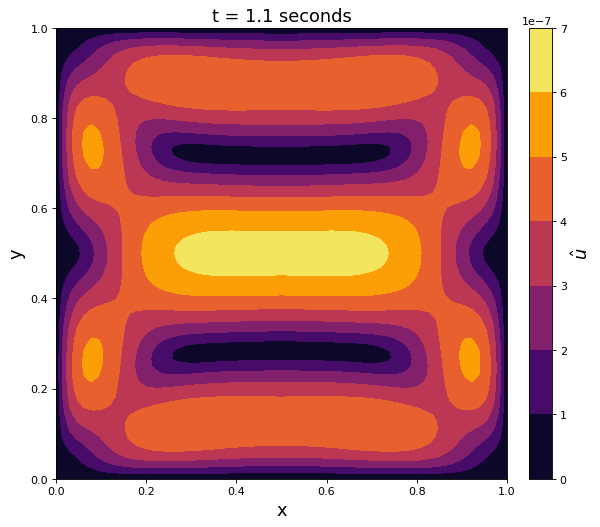

In [12]:
# plot final result and save figure

fig = plt.figure(figsize=(8, 8), dpi=80);
ax = fig.add_subplot(111);

div = make_axes_locatable(ax);
cax = div.append_axes('right', '5%', '5%');

ax.clear()
colors = tricontourf(results[-1], axes=ax, cmap='inferno')
ax.set_aspect("equal")
cax.cla()
cb = fig.colorbar(colors, cax=cax)
ax.set_title('t = {} seconds'.format('1.1'), fontsize=16)
ax.set_xlabel('x', fontsize=16)
ax.set_ylabel('y', fontsize=16)
cb.set_label('$\hat{u}$', fontsize=16)

fig.savefig('images/chaotic.png')

## Results 

$Ra$ = 2e4

$Pr$ = 1

dt = .1

![SegmentLocal](images/results.gif "segment")